# Modulo 5: Visualización de datos

En este ejemplo práctico vamos a construir un mapa coroplético, el cual es una herramienta últil para visualizar variaciones de una variable estadística en un área geográfica. Usando la base de datos de contagios por COVID-19 para el año 2020, vamos a gráficar su comportamiento por municipio.

Para trabajar con datos georeferenciados necesitamos la librería **GeoPandas**, que es una extensión de la librería **Pandas** con la que ya hemos trabajado. 



### Librerias necesarias:

In [1]:
#Importamos las librerias que se utilizarán

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#Para el trabajo con datos geoespaciales
import geopandas

### Importamos las bases de datos:

Empecemos importando la base de datos de casos positivos de COVID-19 para el año 2022.

In [2]:
covid2022 = pd.read_csv('Casos_positivos_COVID_2022.csv') 
covid2022.head()

,year,mes,dia,caso,divipola_depto,depto,divipola_mpio,mpio,edad,grupo_edad,sexo,contagio,fecha_diag,fecha_inicio
0,2022,1,23,5765904,25,CUNDINAMARCA,25899,ZIPAQUIRA,27,15-28,Masculino,Comunitaria,2022-01-23,2022-01-08
1,2022,1,13,5768377,50,META,50001,VILLAVICENCIO,30,29-59,Masculino,Comunitaria,2022-01-13,2022-01-11
2,2022,1,24,5765566,54,NORTE SANTANDER,54405,LOS PATIOS,35,29-59,Femenino,Comunitaria,2022-01-24,2022-01-09
3,2022,1,24,5765567,54,NORTE SANTANDER,54001,CUCUTA,36,29-59,Femenino,Comunitaria,2022-01-24,2022-01-09
4,2022,1,24,5765568,54,NORTE SANTANDER,54001,CUCUTA,36,29-59,Femenino,Comunitaria,2022-01-24,2022-01-16


En primer lugar, debemos calcular el número de contagios por municipio. 

Para esto utilizaremos las funciones `.groupby( )` y `.size( )`; la primera nos agrupará la información a nivel de municipio, y la segunda calcula el número de casos al interior de cada municipio.

In [3]:
covid_mun = covid2022.groupby('divipola_mpio').size()
print(type(covid_mun))
covid_mun.head()

<class 'pandas.core.series.Series'>


divipola_mpio
5001    101472
5002        45
5004         6
5021         5
5030       150
dtype: int64

El resultado de las funciones anteriores es una Serie, por lo que luego utilizamos la función `.to_frame( )` para nuevamente tener un DataFrame, indicando que el nombre de la variable de tamaño sea *n_casos*.

In [4]:
covid_mun = covid_mun.to_frame(name="n_casos")
print(type(covid_mun))
covid_mun.head()

<class 'pandas.core.frame.DataFrame'>


,n_casos
divipola_mpio,
5001,101472
5002,45
5004,6
5021,5
5030,150


Es momento de obtener la información geoespacial de los municipios de Colombia, la cual podemos descargar directamente del Geoportal del DANE a través del siguiente [enlace](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/descarga-mgn-marco-geoestadistico-nacional/#gsc.tab=0). Para este ejercicio, vamos a utilizar el Marco Geoestadistico Nacional (MGN) a nivel de municipio para el año 2021.

El archivo que debemos descargar se encuentra en formato shapefile. Este formato de archivo contiene la información de las entidades geográficas (en nuestro caso, municipios representados en polígonos).  

Para importar el shapefile, utilizamos la función `geopandas.read_file( )`.

In [5]:
municipios_shp = geopandas.read_file(r'MGN_MPIO_POLITICO.shp')
municipios_shp.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360..."
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048..."
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585..."
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491..."


In [6]:
municipios_shp.dtypes

DPTO_CCDGO      object
MPIO_CCDGO      object
MPIO_CDPMP      object
DPTO_CNMBR      object
MPIO_CNMBR      object
MPIO_CRSLC      object
MPIO_NAREA     float64
MPIO_CSMBL      object
MPIO_VGNC        int64
MPIO_TIPO       object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

Es necesario que los códigos que identifican los municipios en ambas bases sean los mismos. En este caso, en la base de datos de contagios por COVID-19, la variable *divipola_mpio* es númerica, mientras que la variable *MPIO_CDPMP* en el shapefile es una cadena de texto. Para transformar *MPIO_CDPMP* en una variable númerica utlizamos la función `pd.to_numeric( )`.

In [7]:
municipios_shp['MPIO_CDPMP1'] = pd.to_numeric(municipios_shp['MPIO_CDPMP'])

Es momento de unir la información de ambas bases de datos. Para esto utilizamos la función `pd.merge( )`. Al interior indicamos los DataFrames que queremos unir. En el argumento ***how*** indicamos "left", lo que significa que queremos conservar únicamente las observaciones que se encuentran en la base de datos de la izquierda (en este caso **covid_mun**). También indicamos que la llave que vamos a utilizar en ambas bases de datos está en el índice (con el argumento ***left_index*** y ***right_index***), por lo que previamente definimos el índice de la base **municipios_shp** con la función `.set_index( )`.

In [8]:
municipios_shp = municipios_shp.set_index('MPIO_CDPMP1')
covid_mun = pd.merge(municipios_shp, covid_mun, how="left",left_index=True, right_index=True)

<AxesSubplot:>

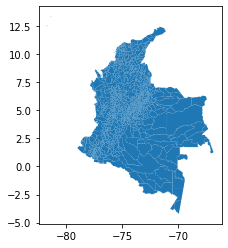

In [9]:
covid_mun.plot()

Clasificación por intervalos iguales:

<AxesSubplot:>

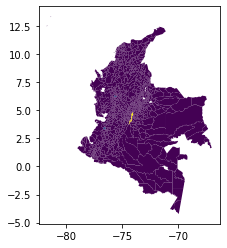

In [10]:
covid_mun.plot(column = 'n_casos', scheme='equal_interval')

Clasificación por cuantiles:

<AxesSubplot:>

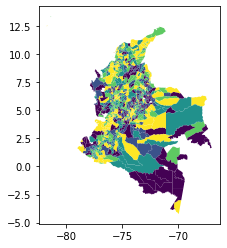

In [11]:
covid_mun.plot(column = 'n_casos', scheme='Quantiles')

<AxesSubplot:>

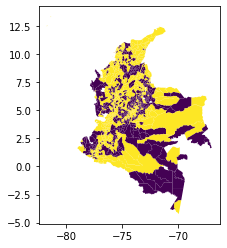

In [12]:
covid_mun.plot(column = 'n_casos', scheme='Quantiles', k=2)

Seleccionando el color: 

<AxesSubplot:>

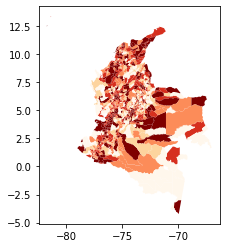

In [13]:
covid_mun.plot(column = 'n_casos', scheme='Quantiles', cmap='OrRd')

Text(0.5, 1.0, 'Número de contagios de COVID-19 en 2022')

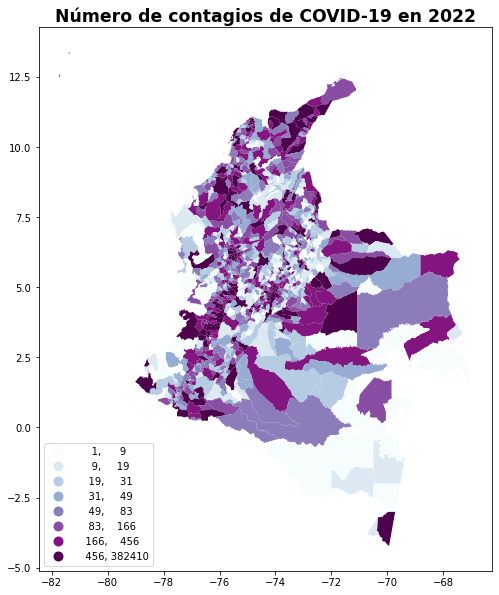

In [14]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
covid_mun.plot(column = 'n_casos', scheme='Quantiles', k=8, cmap='BuPu', 
               legend = True, ax = ax, legend_kwds={'loc': 'lower left', "fmt": "{:.0f}"})
ax.set_title('Número de contagios de COVID-19 en 2022', fontsize = 'xx-large', fontweight = 'bold')

In [15]:
covid_mun["n_casos_area"] = covid_mun["n_casos"]/covid_mun["Shape_Area"]

Corrigiendo por tamaño de los municipios:

Text(0.5, 1.0, 'Número de contagios de COVID-19 por área en 2022')

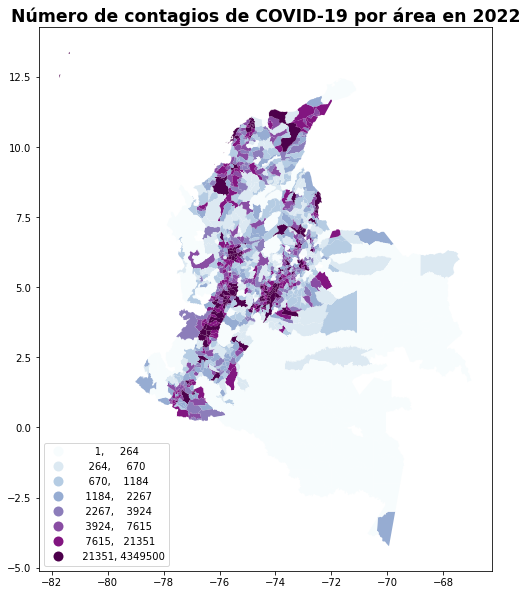

In [16]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
covid_mun.plot(column = 'n_casos_area', scheme='Quantiles', k=8, cmap='BuPu', 
               legend = True, ax = ax, legend_kwds={'loc': 'lower left', "fmt": "{:.0f}"})
ax.set_title('Número de contagios de COVID-19 por área en 2022', fontsize = 'xx-large', fontweight = 'bold')